## An example how to calculate sdg 11.2 indicator for Nairobi

In [1]:
import os
import sys
project_path = os.path.abspath('../')
sys.path.append(project_path)
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt

from ptac import accessibility as accessibility
from ptac import osm as osm
from ptac import population as population

Load stops and population data and generate boundary from population data.
The boundary is necessary to download the network afterwards.

In [2]:
stops_high_capacity = gpd.read_file(project_path + "/data/nairobi_pt_high.gpkg")
stops_low_capacity = gpd.read_file(project_path + "/data/nairobi_pt_low.gpkg")

In [3]:
stops = pd.concat([stops_low_capacity, stops_high_capacity])

In [4]:
population_points = gpd.read_file(project_path + "/data/nairobi_population.gpkg")
boundary_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326',
                                geometry=[population_points.unary_union.convex_hull])

Plot population and pt stops

<AxesSubplot:>

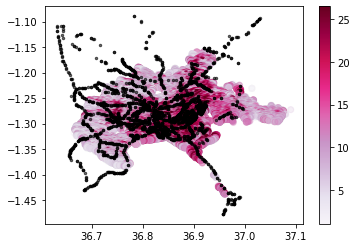

In [6]:
ax = population_points.plot(column= "pop", cmap='PuRd', legend=True, alpha=0.1)

stops.plot(color="black", ax=ax, markersize=6, alpha=0.6)

Calculate sum of population in the focus area

In [7]:
population_sum = population_points["pop"].sum()

print(f"Overall sum of population is: {population_sum}")

Overall sum of population is: 4500000.006868482


We can download the network before calculating

In [8]:
network_gdf = osm.get_network(boundary_gdf)

Then, we can have a look at the network..

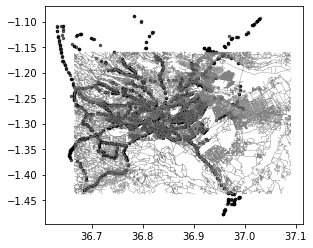

In [9]:
ax = stops.plot(color="black", markersize=6, alpha=0.6)
network_gdf.plot(color="grey", linewidth=0.2, ax=ax)
plt.show()

.. and store it to disk. You are able to drag and drop this data set into your GIS software.

In [ ]:
network_gdf.to_file(project_path + "/data/nairobi_network.gpkg", driver="GPKG")

Now, we can read the data again from disk..

In [ ]:
network_gdf = gpd.read_file(project_path + "/data/nairobi_network.gpkg")

Then, we can have a look at the network..

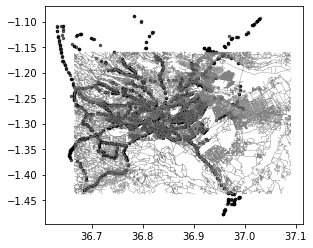

In [10]:
#network_gdf.plot(color="grey", makersize= 4)

ax = stops.plot(color="black", markersize=6, alpha=0.6)
network_gdf.plot(color="grey", linewidth=0.2, ax=ax)
plt.show()

.. and calculate the accessibilities from population point data to high capacity stations (something like subway).
Based on the indicator definition access to low capacity stations should be under 1000 meters.

In [11]:
accessibility_output_high = accessibility.distance_to_closest(
    start_geometries=population_points,
    destination_geometries=stops_high_capacity,
    boundary_geometries=boundary_gdf,
    network_gdf=None,
    transport_system="high-capacity",
    verbose=5)

No street network was specified. Loading osm network..

Preparing street network for routing
Starting UrMoAC to calculate accessibilities

UrMoAC request: java -jar -Xmx12g C:\Anaconda3\envs\ptacserra\lib\site-packages\ptac/urmoacjar/UrMoAccessibilityComputer-0.1-PRERELEASE-shaded.jar --from file;"C:\Users\yosm_se/.ptac/origins.csv" --shortest --to file;"C:\Users\yosm_se/.ptac/destinations.csv" --mode foot --time 35580 --epsg 32637 --ext-nm-output "file;C:\Users\yosm_se/.ptac/sdg_output.csv" --verbose --threads 1 --dropprevious --date 20200915 --net "file;C:\Users\yosm_se/.ptac/network.csv"

calculation finished in 4834.7483814 seconds


.. now, we calculate the accessibilities from population point data to low capacity stations (something like bus).
Based on the indicator definition access to low capacity stations should be under 500 meters.

In [11]:
accessibility_output_low = accessibility.distance_to_closest(
    start_geometries=population_points,
    destination_geometries=stops_low_capacity,
    boundary_geometries=boundary_gdf,
    network_gdf=None,
    transport_system="low-capacity",
    verbose=5)

No street network was specified. Loading osm network..

Preparing street network for routing
Starting UrMoAC to calculate accessibilities

UrMoAC request: java -jar -Xmx12g C:\Anaconda3\envs\ptacserra\lib\site-packages\ptac/urmoacjar/UrMoAccessibilityComputer-0.1-PRERELEASE-shaded.jar --from file;"C:\Users\yosm_se/.ptac/origins.csv" --shortest --to file;"C:\Users\yosm_se/.ptac/destinations.csv" --mode foot --time 35580 --epsg 32637 --ext-nm-output "file;C:\Users\yosm_se/.ptac/sdg_output.csv" --verbose --threads 1 --dropprevious --date 20200915 --net "file;C:\Users\yosm_se/.ptac/network.csv"

calculation finished in 548.8993445999998 seconds


.. out of that, we can calculate the actual indicator.

In [12]:
sdg_low_high = accessibility.calculate_sdg(df_pop_total=population_sum,
                            pop_accessible=[accessibility_output_high, accessibility_output_low],
                            population_column='pop')
print(f"{sdg_low_high} percent of the population have access to low- and high-capacity public transit systems")


NameError: name 'accessibility_output_high' is not defined

.. we can also calculate the accessibilities from population point data to low capacity stations (something like bus).
Based on the indicator definition access to low capacity stations should be under 500 meters.

In [ ]:
accessibility_output = accessibility.distance_to_closest(
    start_geometries=population_points,
    destination_geometries=stops,
    network_gdf= None,
    transport_system=None,
    maximum_distance=500,
    boundary_geometries=boundary_gdf,
    verbose=5)

In [ ]:
sdg_500m = accessibility.calculate_sdg(df_pop_total=population_sum,
                            pop_accessible=accessibility_output,
                            population_column='pop')
print(f"{sdg_500m} percent of the population have access to public transit systems in 500 m")

